In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))

setwd("~/Repositories/AirQualityCOVID/")

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=15,
        repr.plot.height=15,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
variable <- "no2"
html.variable <- c("no" = "NO",
                   "no2" = "NO<sub>2</sub>",
                   "o3" = "O<sub>3</sub>",
                   "pm10" = "PM10",
                   "pm2.5" = "PM2.5"
                  )
method <- "lm"

In [4]:
load(paste("data/Analysis/predictions-",
           method,"-", variable,".rda", sep=""))

sites.lv <- read.csv("data/Curation/checked_AQ.csv") %>%
            filter(Pollutant == variable) 

In [5]:
results <- merge(sites.lv,
                results,
                by = "site", all.y=T
               ) %>% 
        group_by(date, Municipio, latitude, longitude) %>%
        summarise(obs = mean(obs, na.rm=T),
                  pred.qq = mean(pred.qq, na.rm=T)
                 )

`summarise()` has grouped output by 'date', 'Municipio', 'latitude'. You can override using the `.groups` argument.



In [6]:
results <- openair::timeAverage(results, 
                                avg.time = "day", 
                                type = c("Municipio"))
results$date <- lubridate::as_date(results$date)
results$diff <- abs(results$obs - results$pred.qq)

# Lockdown dates

In [7]:
periods <- list(
    # Prelockdown
    pre.lockdown = lubridate::ymd("2020-01-01"),

    # lockdown
    lockdown = lubridate::ymd("2020-03-14"),
    #end.lockdown = ymd_hms("2020-04-28 00:00:00"),

    # poslockdown
    fases = lubridate::ymd("2020-05-01"),
    normalidad = lubridate::ymd("2020-06-21"),

    # New lockdown
    new.lockdown = lubridate::ymd("2020-10-25"),
    end.year = lubridate::ymd("2020-12-31")
)

In [8]:
change <- list(serie = data.frame(),
               speed = data.frame())

for (nm in levels(results$Municipio)) {
    for (i in 2:length(periods)) {
        dat <- results %>% 
                filter(Municipio == nm,
                       date >= periods[[i-1]],
                       date <= periods[[i]],
                       diff < Inf
                      )
        if (nrow(dat) == 0) {next()}
        
        dat.model <- lm(diff ~ date, data = dat, na.action = na.omit)
        
        change[["speed"]] <- rbind(change[["speed"]],
                              data.frame(Municipio = nm,
                                         latitude=dat$latitude[1],
                                         longitude=dat$longitude[1],
                                         period = names(periods)[i-1],
                                         speed = dat.model$coefficients[2]
                                  ))
        change[["serie"]] <- rbind(change[["serie"]],
                              data.frame(Municipio = nm,
                                         period = names(periods)[i-1],
                                         date = dat$date,
                                         diff = dat$diff,
                                         fit = predict(dat.model))
                             )
    }
}

In [9]:
head(change[["speed"]], 5) %>%
    select(Municipio, period, speed)

,Municipio,period,speed
,<chr>,<chr>,<dbl>
date,Alcalá de Henares,pre.lockdown,-0.03471795
date1,Alcalá de Henares,lockdown,-0.13893416
date2,Alcalá de Henares,fases,-0.08627647
date3,Alcalá de Henares,normalidad,0.06910522
date4,Alcalá de Henares,new.lockdown,0.03271670


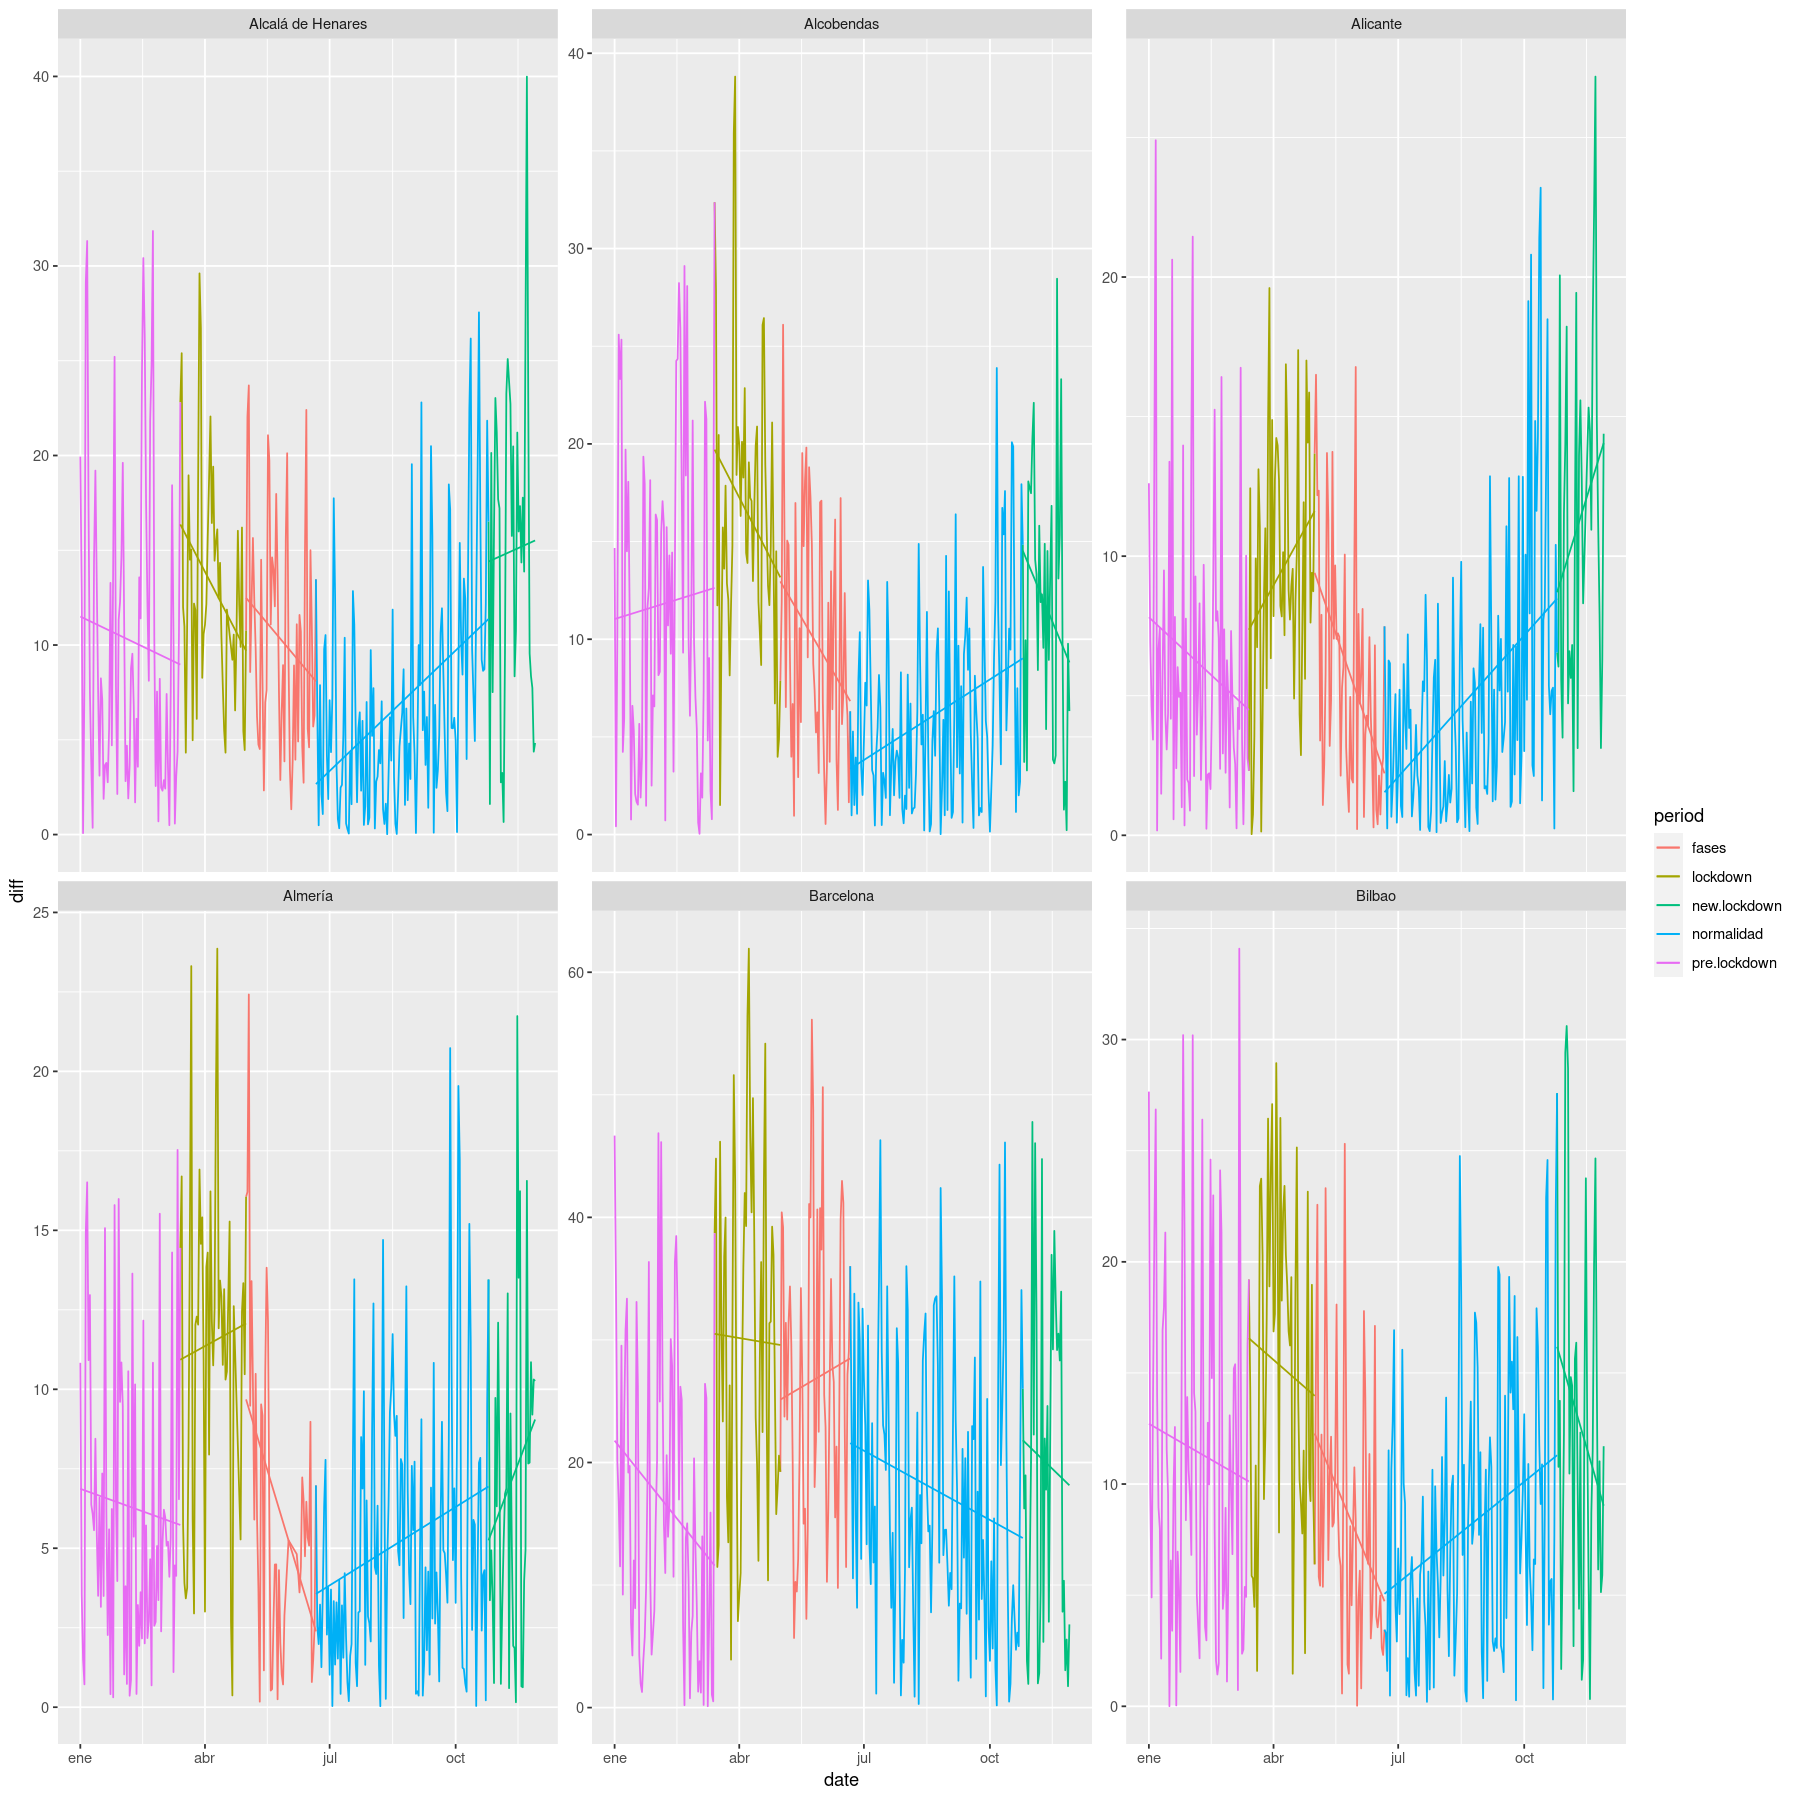

In [10]:
ggplot(change[["serie"]] %>% filter(Municipio %in% levels(results$Municipio)[1:6])) +
    geom_line(aes(x=date, y=diff, color=period)) +
    geom_line(aes(x=date, y=fit, color=period)) +
    facet_wrap(~Municipio, scale="free_y")

---

In [11]:
library(leaflet)
library(leaflet.extras)
library(htmlwidgets)
library(htmltools)

In [12]:
rr <- tags$div(HTML(paste(
    "<h3>", html.variable[[variable]],"</h3>"))
 ) 

beatCol <- colorNumeric(palette = 'RdYlGn', 
                        domain = change[["speed"]]$speed,
                        na.color = "transparent",
                        #reverse = T,
                       )

map <- leaflet(change[["speed"]],
               options = leafletOptions(minZoom = 5, 
                                        maxZoom = 9)) %>%
            addControl(rr, position = "topright")  %>%
            addProviderTiles(providers$CartoDB.Positron)%>% 
            #addTiles() %>% # Add default OpenStreetMap map tiles
            addLayersControl(position="bottomleft", 
                             baseGroups = names(periods)[-6],
                             options = layersControlOptions(
                                         collapsed = FALSE
                                         )
                            )%>% 
            addCircleMarkers(~longitude, 
                             ~latitude, 
                             color=~beatCol(speed),
                             radius=10,
                             fillOpacity=0.9,
                             stroke=FALSE,
                             group=~period,
                             popup = paste(change[["speed"]]$Municipio, ": ",
                                           change[["speed"]]$speed, "", sep="")
                            )%>%
            addLegend("topleft", 
                       pal = beatCol, 
                       values = ~speed,
                       title = "speed",
                       #labFormat = labelFormat(suffix = ""),
                       opacity = 1,
                       )

In [13]:
map

HTML widgets cannot be represented in plain text (need html)